#  PRCP-1016 — Heart Disease Prediction

Dataset: values.csv (features) + labels.csv (target)

Domain: Healthcare

Introduction

This project focuses on predicting heart disease using machine learning techniques.
The dataset is divided into two files: values.csv (features) and labels.csv (target).

Workflow:

1. Perform Exploratory Data Analysis (EDA)

2. Apply data preprocessing

3. Train multiple ML models

4. Evaluate performance metrics


1. Libraries Import

In [5]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Preprodessing & model selection
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Helper to compute metrics
def metrics_dict(y_true, y_pred, y_proba=None):
    d = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            d['roc_auc'] = roc_auc_score(y_true, y_proba)
        except Exception:
            d['roc_auc'] = np.nan
    else:
        d['roc_auc'] = np.nan
    return d

2. Data Loading

In [23]:
X = pd.read_csv("values.csv")
labels = pd.read_csv("labels.csv")

# Target column is heart_disease_present
y = labels["heart_disease_present"].astype(int)

print("X shape:", X.shape, " | y shape:", y.shape)
print("Unique values in target:", y.unique())

X shape: (180, 14)  | y shape: (180,)
Unique values in target: [0 1]


3. Exploratory Data Analysis (EDA)

In [24]:
# Summary statistics
print(X.describe(include="all").transpose())

                                      count unique     top freq        mean  \
patient_id                              180    180  0z64un    1         NaN   
slope_of_peak_exercise_st_segment     180.0    NaN     NaN  NaN        1.55   
thal                                    180      3  normal   98         NaN   
resting_blood_pressure                180.0    NaN     NaN  NaN  131.311111   
chest_pain_type                       180.0    NaN     NaN  NaN    3.155556   
num_major_vessels                     180.0    NaN     NaN  NaN    0.694444   
fasting_blood_sugar_gt_120_mg_per_dl  180.0    NaN     NaN  NaN    0.161111   
resting_ekg_results                   180.0    NaN     NaN  NaN        1.05   
serum_cholesterol_mg_per_dl           180.0    NaN     NaN  NaN  249.211111   
oldpeak_eq_st_depression              180.0    NaN     NaN  NaN        1.01   
sex                                   180.0    NaN     NaN  NaN    0.688889   
age                                   180.0    NaN  

In [25]:
# Missing values
print("Missing values:\n", X.isna().sum())

Missing values:
 patient_id                              0
slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64


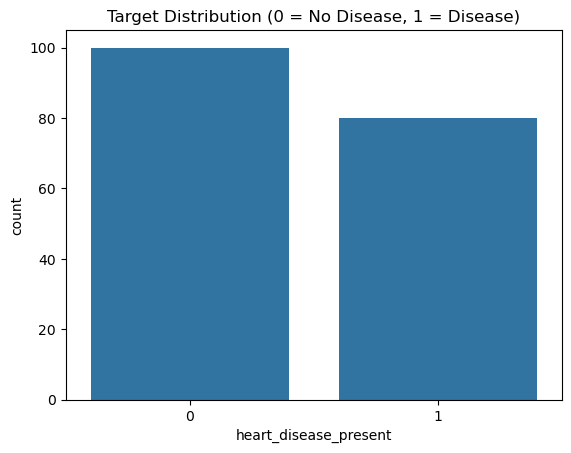

In [26]:
# Target distribution
sns.countplot(x=y)
plt.title("Target Distribution (0 = No Disease, 1 = Disease)")
plt.show()

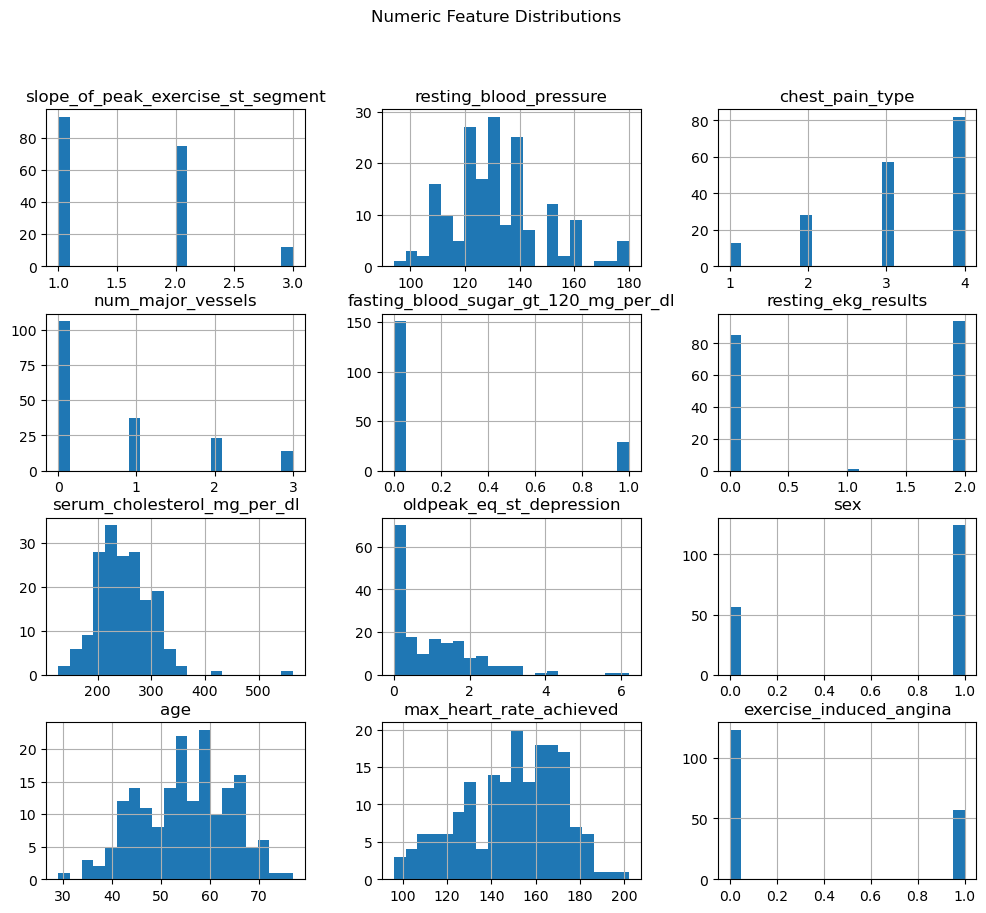

In [27]:
# Numeric distributions
X.hist(bins=20, figsize=(12, 10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

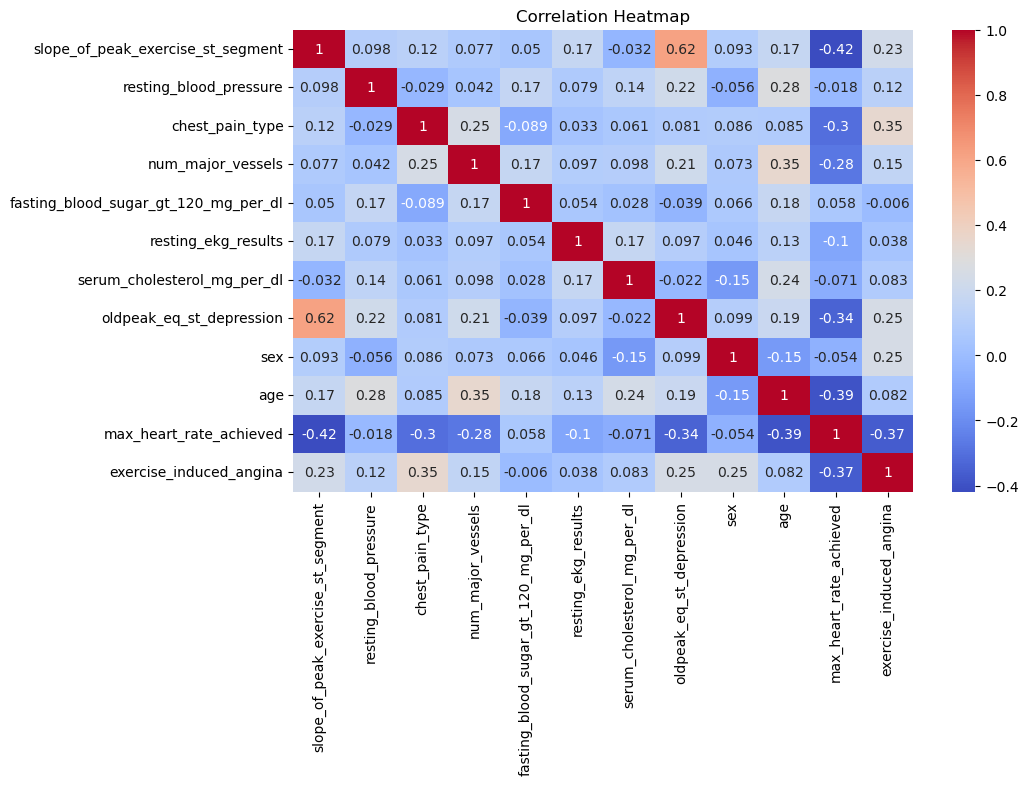

In [28]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

4. Train/Test Split

In [29]:
# Identify categorical and numeric columns
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train set size:", X_train.shape, " Test set size:", X_test.shape)

Train set size: (144, 14)  Test set size: (36, 14)


5. Prepocessing

In [30]:
# Numeric pipeline: handle missing values + scale
num_proc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: handle missing + one-hot encode
cat_proc = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numeric + categorical transformers
preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols)
])

6. Model Training & Evaluation

   We train multiple models and compare performance

* Logistic Regression

In [34]:
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE))
])
logreg.fit(X_train, y_train)
print("Logistic Regression:", metrics_dict(y_test, logreg.predict(X_test), logreg.predict_proba(X_test)[:,1]))

Logistic Regression: {'accuracy': 0.8333333333333334, 'precision': 0.7777777777777778, 'recall': 0.875, 'f1': 0.8235294117647058, 'roc_auc': 0.940625}


* Decision Tree

In [36]:
dtree = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE))
])
dtree.fit(X_train, y_train)
print("Decision Tree:", metrics_dict(y_test, dtree.predict(X_test), dtree.predict_proba(X_test)[:,1]))

Decision Tree: {'accuracy': 0.8055555555555556, 'precision': 0.8, 'recall': 0.75, 'f1': 0.7741935483870968, 'roc_auc': 0.8}


* Random Forest

In [37]:
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_STATE))
])
rf.fit(X_train, y_train)
print("Random Forest:", metrics_dict(y_test, rf.predict(X_test), rf.predict_proba(X_test)[:,1]))


Random Forest: {'accuracy': 0.8888888888888888, 'precision': 0.8333333333333334, 'recall': 0.9375, 'f1': 0.8823529411764706, 'roc_auc': 0.9453125}


* Gradient Boosting

In [38]:
gb = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])
gb.fit(X_train, y_train)
print("Gradient Boosting:", metrics_dict(y_test, gb.predict(X_test), gb.predict_proba(X_test)[:,1]))

Gradient Boosting: {'accuracy': 0.8611111111111112, 'precision': 0.8235294117647058, 'recall': 0.875, 'f1': 0.8484848484848485, 'roc_auc': 0.95}


* Support Vector Classifier

In [39]:
svc = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
])
svc.fit(X_train, y_train)
print("SVC:", metrics_dict(y_test, svc.predict(X_test), svc.predict_proba(X_test)[:,1]))

SVC: {'accuracy': 0.8055555555555556, 'precision': 0.7368421052631579, 'recall': 0.875, 'f1': 0.8, 'roc_auc': 0.9437500000000001}


* k-Nearest Neighbors

In [40]:
knn = Pipeline([
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=15))
])
knn.fit(X_train, y_train)
print("KNN:", metrics_dict(y_test, knn.predict(X_test), knn.predict_proba(X_test)[:,1]))


KNN: {'accuracy': 0.9166666666666666, 'precision': 0.8823529411764706, 'recall': 0.9375, 'f1': 0.9090909090909091, 'roc_auc': 0.9484374999999999}


7. Results Comparison

In [41]:
results = {
    "Logistic Regression": metrics_dict(y_test, logreg.predict(X_test), logreg.predict_proba(X_test)[:,1]),
    "Decision Tree":       metrics_dict(y_test, dtree.predict(X_test),  dtree.predict_proba(X_test)[:,1]),
    "Random Forest":       metrics_dict(y_test, rf.predict(X_test),     rf.predict_proba(X_test)[:,1]),
    "Gradient Boosting":   metrics_dict(y_test, gb.predict(X_test),     gb.predict_proba(X_test)[:,1]),
    "SVC":                 metrics_dict(y_test, svc.predict(X_test),    svc.predict_proba(X_test)[:,1]),
    "KNN":                 metrics_dict(y_test, knn.predict(X_test),    knn.predict_proba(X_test)[:,1]),
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="roc_auc", ascending=False)

print("Model Comparison Table:")
display(results_df)

Model Comparison Table:


,accuracy,precision,recall,f1,roc_auc
Gradient Boosting,0.861111,0.823529,0.8750,0.848485,0.950000
KNN,0.916667,0.882353,0.9375,0.909091,0.948437
Random Forest,0.888889,0.833333,0.9375,0.882353,0.945312
SVC,0.805556,0.736842,0.8750,0.800000,0.943750
Logistic Regression,0.833333,0.777778,0.8750,0.823529,0.940625
Decision Tree,0.805556,0.800000,0.7500,0.774194,0.800000


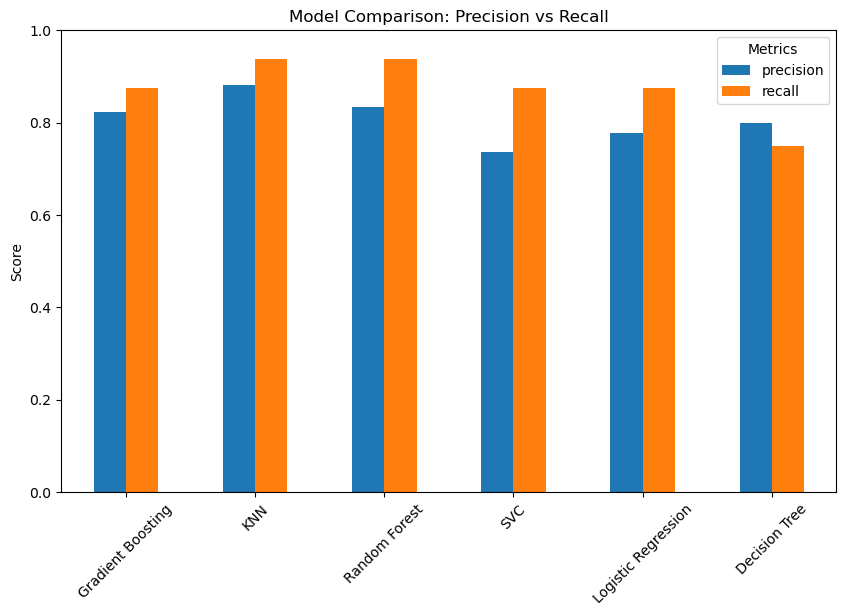

In [42]:
metrics_to_plot = ["precision", "recall"]

results_plot = results_df[metrics_to_plot]

results_plot.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Precision vs Recall")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

8. Best Model

* KNN is the best overall model, achieving both the highest recall (93.8%) and highest      precision (88.2%).
* For heart disease prediction, KNN is recommended since it minimizes false negatives       (high recall) while maintaining strong precision.